In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP, calc_coverage
from preprocess_data import recode_variables_NHANES, recode_variables_LOOK_AHEAD, split_train_cal_test
import os
import matplotlib.pyplot as plt

In [3]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
plots_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/plots'
df_init = pd.read_csv(f_path, na_values="None")
df_init = df_init.replace(to_replace=' ', value=np.nan)
df_init = recode_variables_NHANES(df_init)

In [4]:
GENDER = 'MALE'


In [5]:
ed_dummies = ['ED_LESS_HS', 'ED_HS_GED', 'ED_SOME_COLL_AA', 'ED_COLL_ABOVE', 'ED_OTHR_DK']
race_dummies = ['HISPANIC', 'WHITE', 'BLACK', 'OTHER_MIXED']

NHANES

In [6]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

alpha = 0.05
n_resamplings = 25

# Create an empty DataFrame to store results
all_data = pd.DataFrame()

# Create empty lists to store coverage values for both no calibration and calibration cases
no_cal_cov = []
cp_cov = []

# Define various alpha values and reverse the order for later iteration
alphas = [0.2, 0.1, 0.05, 0.01]
alphas.reverse()

# Iterate over the different alpha values
for alpha in alphas:
    # For each alpha value, perform the operations for a given number of resamplings
    for i in range(n_resamplings):
        # Copy the initial DataFrame and remove any rows with missing values
        df = df_init.copy()
        df.dropna(inplace=True)
        
        # Sample a subset of the data and define the predictor variables and the outcome variable
        # df = df.sample(n = 10000)

        if GENDER == 'FEMALE':
            df = df[df['FEMALE'] == 1]
        else:
            df = df[df['FEMALE'] == 0]
    

        X = df[['AGE', 'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]
        outcome = 'WAIST'
        y = df[[outcome]]
        y = y[outcome].astype(float)

        # Split the data into training, calibration, and test sets
        NHANES_X, NHANES_y = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25, random_state=i)
    
        # Train a quantile regression model using the training and calibration data
        reg = CP(NHANES_X['train'], NHANES_X['cal'], NHANES_y['train'], NHANES_y['cal'], alpha=alpha, regressor="QR", verbose=0)
        reg.train()
        reg.calc_qhat()

        # Predict quantiles for the test set, both with and without calibration
        cp_df = reg.predict_cp_quantiles(NHANES_X['test'], NHANES_y['test'])
        no_cp_df = reg.predict_mdl_quantiles(NHANES_X['test'], y_true= NHANES_y['test'])
        
        # Calculate coverage for both sets of predictions
        cov_no_cal = calc_coverage(no_cp_df)
        cov = calc_coverage(cp_df)
        
        # Append the calculated coverages to their respective lists
        no_cal_cov.append(cov_no_cal)
        cp_cov.append(cov)
        
        # Add results to the all_data DataFrame
        tmp_dict = {'alpha': alpha,
                    'cp': True,
                    'coverage': cov}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        
        tmp_dict = {'alpha': alpha,
                    'cp': False,
                    'coverage': cov_no_cal}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        
        # Print the results for the current iteration
        print(f"{i}: no-cp: {cov_no_cal}, cp: {cov}")

0: no-cp: 0.9890985324947589, cp: 0.9918238993710692
1: no-cp: 0.9920335429769392, cp: 0.9943396226415094
2: no-cp: 0.9872117400419287, cp: 0.990356394129979
3: no-cp: 0.9882599580712789, cp: 0.9857442348008386
4: no-cp: 0.9905660377358491, cp: 0.9932914046121594
5: no-cp: 0.9893081761006289, cp: 0.9916142557651991
6: no-cp: 0.9867924528301887, cp: 0.989937106918239
7: no-cp: 0.989937106918239, cp: 0.989937106918239
8: no-cp: 0.9953878406708595, cp: 0.9953878406708595
9: no-cp: 0.989517819706499, cp: 0.9888888888888889
10: no-cp: 0.9857442348008386, cp: 0.9876310272536688
11: no-cp: 0.989937106918239, cp: 0.9905660377358491
12: no-cp: 0.9905660377358491, cp: 0.9922431865828092
13: no-cp: 0.9874213836477987, cp: 0.990146750524109
14: no-cp: 0.9916142557651991, cp: 0.9928721174004193
15: no-cp: 0.9905660377358491, cp: 0.9962264150943396
16: no-cp: 0.9867924528301887, cp: 0.989517819706499
17: no-cp: 0.989937106918239, cp: 0.9905660377358491
18: no-cp: 0.9893081761006289, cp: 0.9903563941

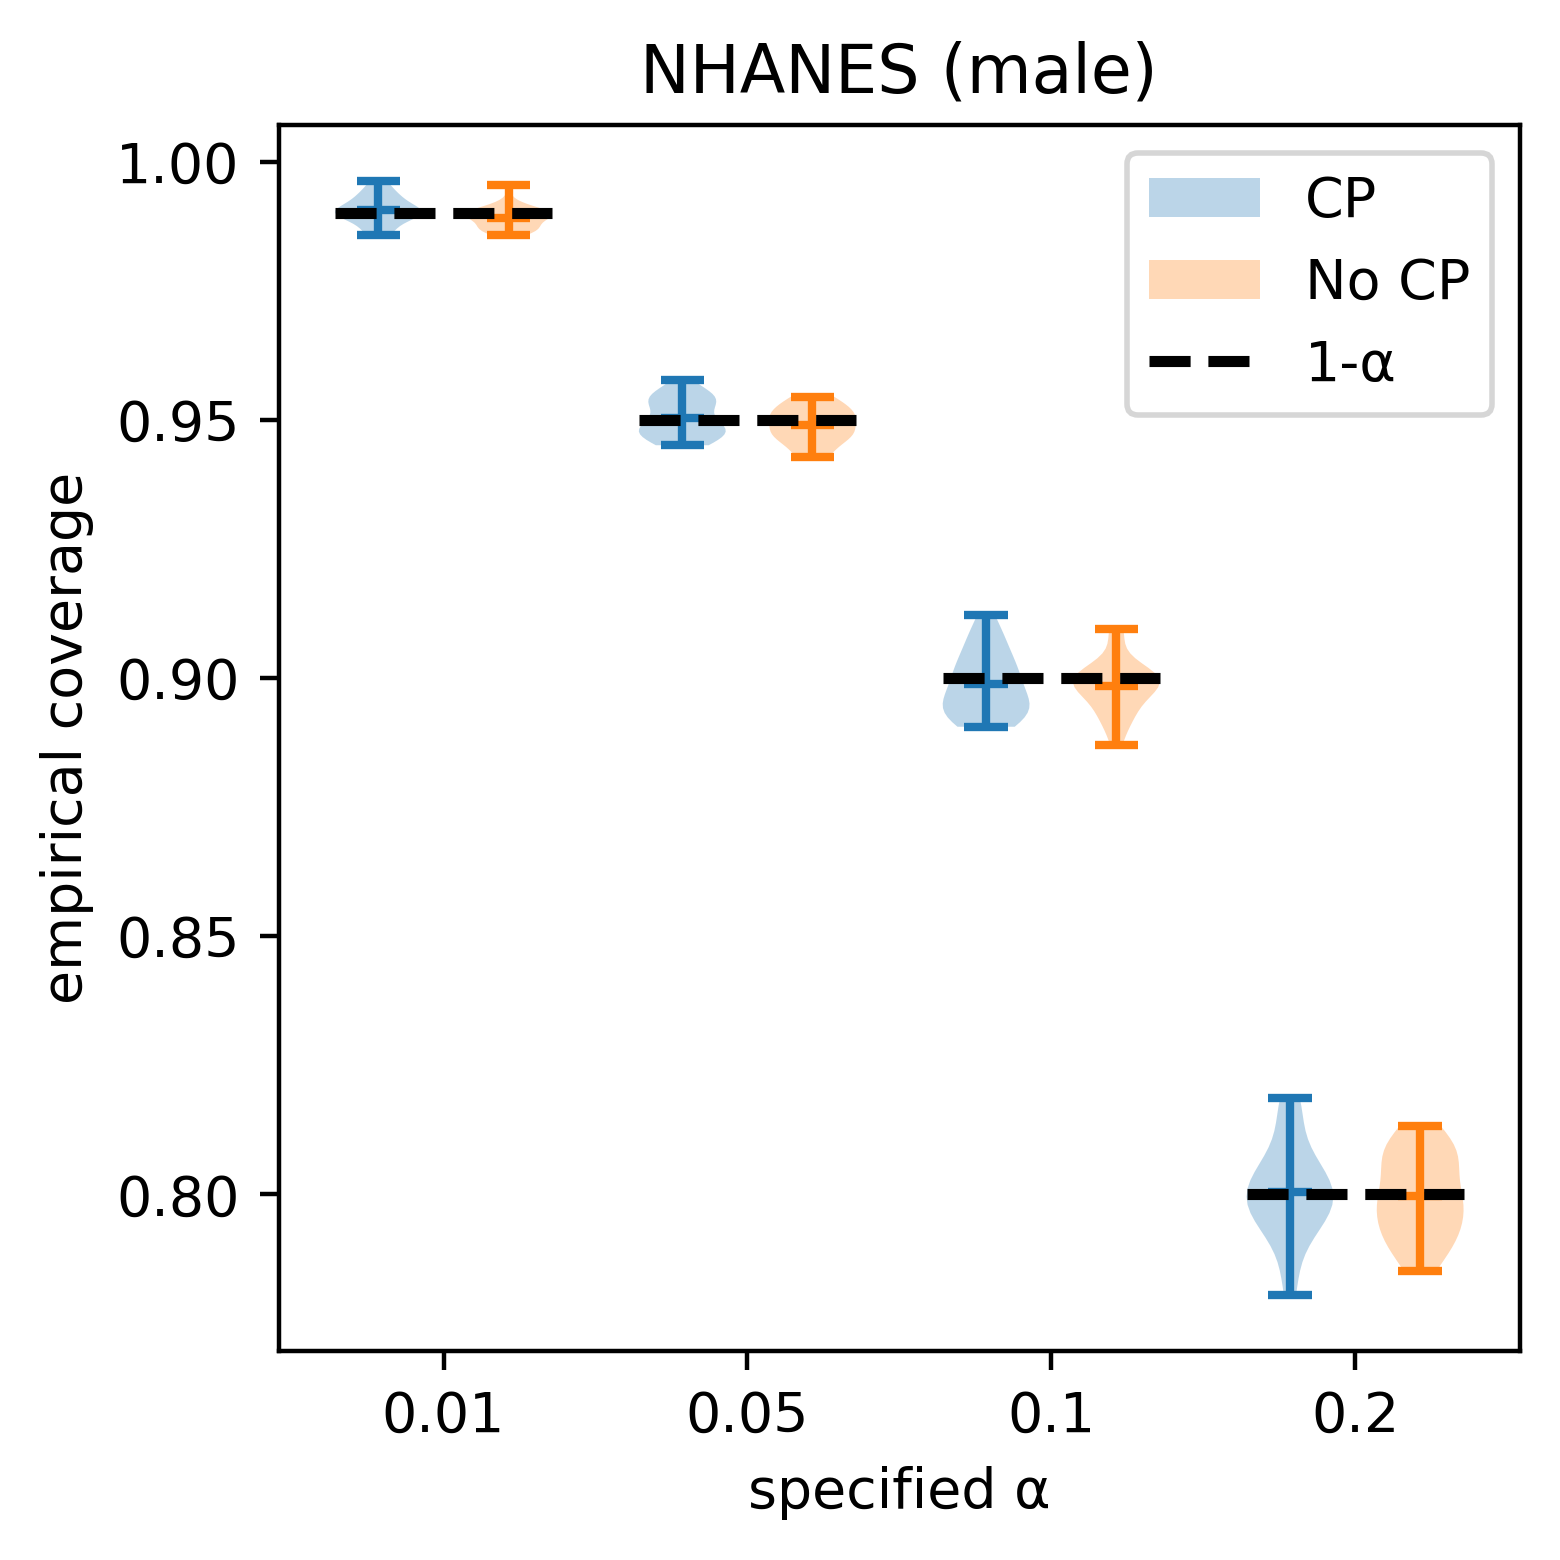

In [7]:
plt.figure(figsize=(4, 4), dpi=400)
cp_data = all_data[all_data['cp'] == 1]
unique_vals = []
for alpha in alphas:
    is_curr = cp_data[cp_data['alpha'] == alpha]
    unique_vals.append(is_curr['coverage'])
v1 = plt.violinplot(dataset=unique_vals, positions=np.arange(1, len(alphas)*1.75, 1.75), showmeans=True, points=n_resamplings)

cp_data = all_data[all_data['cp'] == 0]
unique_vals = []
for alpha in alphas:
    is_curr = cp_data[cp_data['alpha'] == alpha]
    unique_vals.append(is_curr['coverage'])
v2 = plt.violinplot(dataset=unique_vals, positions=np.arange(1.75, len(alphas)*1.75+1, 1.75), showmeans=True, points=n_resamplings)

x_starts = np.arange(0.75, len(alphas)*1.75, 1.75) 
x_stops = np.arange(2, len(alphas)*1.75+1, 1.75) 

for i, alpha in enumerate(alphas):
    p = plt.plot([x_starts[i], x_stops[i]], [1-alpha, 1-alpha], color='black', linewidth=2, linestyle="--")

plt.legend([v1["bodies"][0], v2["bodies"][0], p[0]], ["CP", "No CP", "1-α"])
plt.xticks((x_starts + x_stops)/2, labels=map(str, alphas))

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "NH_resampling_coverage_{gender}.pdf".format(gender=GENDER))
    if GENDER == "MALE":
        plt.title("NHANES (male)")
    else:
        plt.title("NHANES (female)")
else:
    img_path = os.path.join(plots_folder, "NH_resampling_coverage.pdf".format((1-alpha) * 100))
    plt.title("NHANES")

plt.xlabel("specified α")
plt.ylabel("empirical coverage")
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

LOOK AHEAD

In [8]:
f_path = "/Users/carlharris/Documents/AIEM/Diabetes/LOOK AHEAD/Data/Baseline/Analysis_Data/baseline_combined.csv"
LH_df = pd.read_csv(f_path)
LH_df = recode_variables_LOOK_AHEAD(LH_df)
LH_df.dropna(inplace=True)

if GENDER == 'FEMALE':
    LH_df = LH_df[LH_df['FEMALE'] == 1]
else:
    LH_df = LH_df[LH_df['FEMALE'] == 0]
    

/Users/carlharris/VSCode/conformal_prediction_NHANES/preprocess_data.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['RACEVAR'].isnull(), group] = np.nan
/Users/carlharris/VSCode/conformal_prediction_NHANES/preprocess_data.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['RACEVAR'].isnull(), group] = np.nan
/Users/carlharris/VSCode/conformal_prediction_NHANES/preprocess_data.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [9]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

alpha = 0.05
n_resamplings = 25

all_data = pd.DataFrame()

no_cal_cov = []
cp_cov = []

alphas = [0.2, 0.1, 0.05, 0.01]
alphas.reverse()

for alpha in alphas:
    for i in range(n_resamplings):
        df = df_init.copy()
        df.dropna(inplace=True)
        
        # df = df.sample(n = 10000)
        
        if GENDER == 'FEMALE':
            df = df[df['FEMALE'] == 1]
        else:
            df = df[df['FEMALE'] == 0]

        X = df[[ 'AGE', 'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]        
        outcome = 'WAIST'
        y = df[[outcome]]
        y = y[outcome].astype(float)

        NHANES_X, NHANES_y = split_train_cal_test(X, y, trn_prop=0.75, cal_prop=0.24, random_state=i)
    
        reg = CP(NHANES_X['train'], NHANES_X['cal'], NHANES_y['train'], NHANES_y['cal'], alpha=alpha, regressor="QR", verbose=0)
        reg.train()
        
        X = LH_df[[ 'AGE', 'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]
        outcome = 'WAIST'
        y = LH_df[[outcome]]
        y = y[outcome].astype(float)

        LH_X, LH_y = split_train_cal_test(X, y, trn_prop=0.01, cal_prop=0.5, random_state=i)

        reg.calc_qhat(LH_X['cal'], LH_y['cal'])
        cp_df = reg.predict_cp_quantiles(LH_X['test'], LH_y['test'])
        no_cp_df = reg.predict_mdl_quantiles(LH_X['test'], y_true= LH_y['test'])
        
        cov_no_cal = calc_coverage(no_cp_df)
        cov = calc_coverage(cp_df)
        
        no_cal_cov.append(cov_no_cal)
        cp_cov.append(cov)
        
        tmp_dict = {'alpha': alpha,
                    'cp': True,
                    'coverage': cov}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        tmp_dict = {'alpha': alpha,
                    'cp': False,
                    'coverage': cov_no_cal}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        
        print(f"{i}: no-cp: {cov_no_cal}, cp: {cov}")

0: no-cp: 0.9577464788732394, cp: 0.993963782696177
1: no-cp: 0.9698189134808853, cp: 0.9849094567404426
2: no-cp: 0.96579476861167, cp: 0.993963782696177
3: no-cp: 0.7766599597585513, cp: 0.9949698189134809
4: no-cp: 0.772635814889336, cp: 0.9989939637826962
5: no-cp: 0.9698189134808853, cp: 0.9879275653923542
6: no-cp: 0.9647887323943662, cp: 0.9929577464788732
7: no-cp: 0.9748490945674044, cp: 0.9889336016096579
8: no-cp: 0.9708249496981891, cp: 0.9849094567404426
9: no-cp: 0.9577464788732394, cp: 0.9899396378269618
10: no-cp: 0.7806841046277666, cp: 0.9808853118712274
11: no-cp: 0.9668008048289738, cp: 0.9859154929577465
12: no-cp: 0.9768611670020121, cp: 0.9959758551307847
13: no-cp: 0.7746478873239436, cp: 0.9869215291750503
14: no-cp: 0.9748490945674044, cp: 0.9949698189134809
15: no-cp: 0.9668008048289738, cp: 0.9949698189134809
16: no-cp: 0.783702213279678, cp: 0.9979879275653923
17: no-cp: 0.9758551307847082, cp: 0.9919517102615694
18: no-cp: 0.9768611670020121, cp: 0.9869215

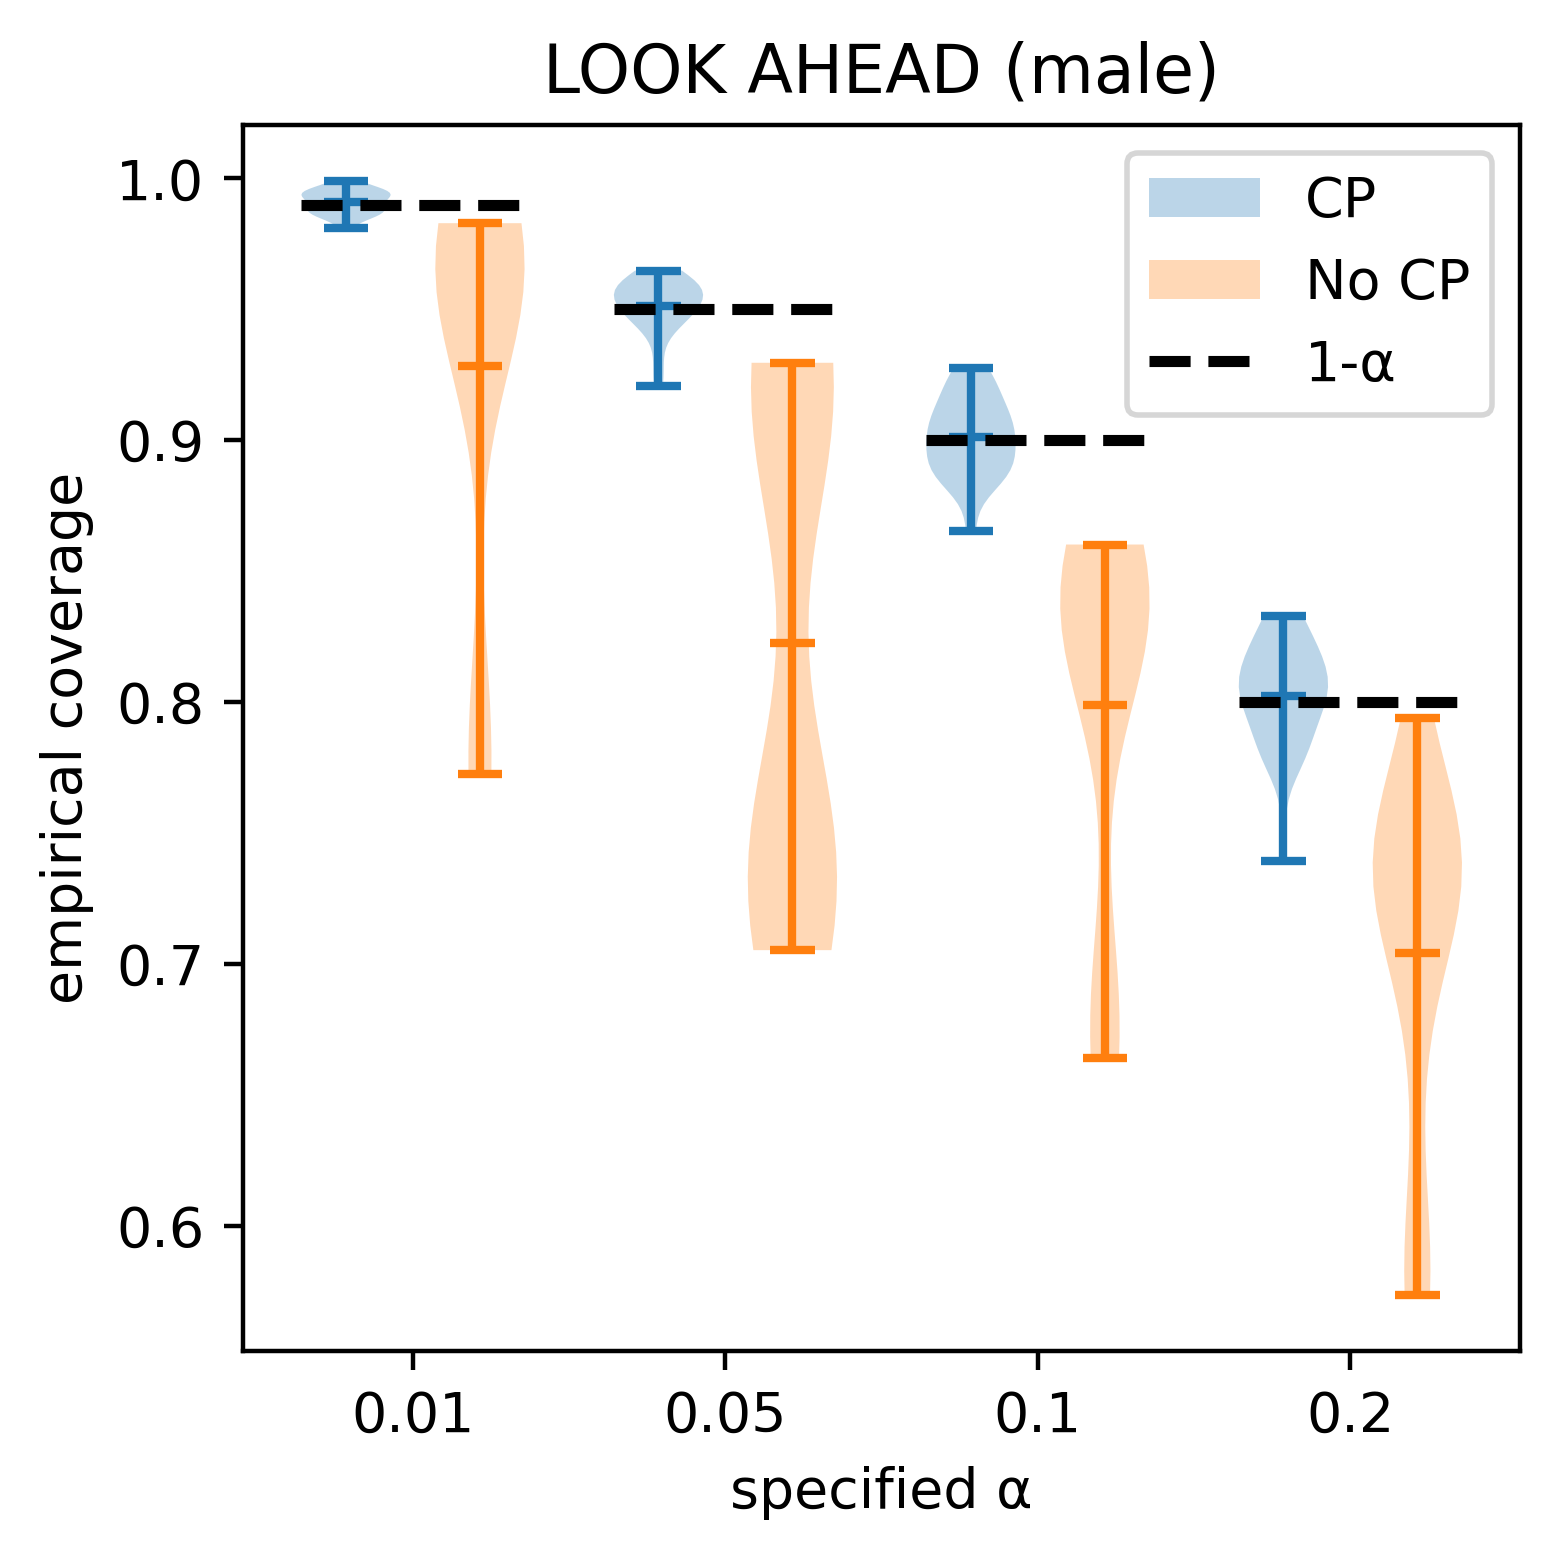

In [10]:
plt.figure(figsize=(4, 4), dpi=400)
cp_data = all_data[all_data['cp'] == 1]
unique_vals = []
for alpha in alphas:
    is_curr = cp_data[cp_data['alpha'] == alpha]
    unique_vals.append(is_curr['coverage'])
v1 = plt.violinplot(dataset=unique_vals, positions=np.arange(1, len(alphas)*1.75, 1.75), showmeans=True, points=n_resamplings)

cp_data = all_data[all_data['cp'] == 0]
unique_vals = []
for alpha in alphas:
    is_curr = cp_data[cp_data['alpha'] == alpha]
    unique_vals.append(is_curr['coverage'])
v2 = plt.violinplot(dataset=unique_vals, positions=np.arange(1.75, len(alphas)*1.75+1, 1.75), showmeans=True, points=n_resamplings)

x_starts = np.arange(0.75, len(alphas)*1.75, 1.75) 
x_stops = np.arange(2, len(alphas)*1.75+1, 1.75) 

for i, alpha in enumerate(alphas):
    p = plt.plot([x_starts[i], x_stops[i]], [1-alpha, 1-alpha], color='black', linewidth=2, linestyle="--")

plt.legend([v1["bodies"][0], v2["bodies"][0], p[0]], ["CP", "No CP", "1-α"])
plt.xticks((x_starts + x_stops)/2, labels=map(str, alphas))
plt.xlabel("specified α")
plt.ylabel("empirical coverage")

if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "LH_resampling_coverage_{gender}.pdf".format(gender=GENDER))
    if GENDER == "MALE":
        plt.title("LOOK AHEAD (male)")
    else:
        plt.title("LOOK AHEAD (female)")
else:
    img_path = os.path.join(plots_folder, "LH_resampling_coverage.pdf".format((1-alpha) * 100))
    plt.title("LOOK AHEAD")
plt.tight_layout()
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()

Network type

In [ ]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression

alpha = 0.05
n_resamplings = 25

all_data = pd.DataFrame()

no_cal_cov = []
cp_cov = []

models = ["QR", "GBR", "NN"]

for model in models:
    for i in range(n_resamplings):
        df = df_init.copy()
        df.dropna(inplace=True)
        
        df = df.sample(n = 5000)
        ed_dummies = ['Ed_less_9th', 'Ed_9th_11th', 'Ed_HS_GED', 'Ed_some_coll_AA', 'Ed_coll_above', 'Ed_refused', 'Ed_dk']
        eth_dummies = ['Eth_Mex_Am', 'Eth_Oth_Hisp', 'Eth_Nonhisp_White', 'Eth_Nonhisp_Black', 'Eth_Other']
        
        X = df[[ 'Age', 'Female',  'Weight', 'Height', 'BMI'] + ed_dummies + eth_dummies]
        
        outcome = 'Waist'
        y = df[[outcome]]
        y = y[outcome].astype(float)

        X_train, X_cal, X_test, y_train, y_cal, y_test = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)
    
        reg = CP(X_train, X_cal, y_train, y_cal, alpha=alpha, regressor=model, verbose=0)
        reg.train()
        reg.calc_qhat()
        cp_df = reg.predict_cp_quantiles(X_test, y_test)
        no_cp_df = reg.predict_mdl_quantiles(X_test, y_true= y_test)
        
        cov_no_cal = np.mean(cp_df['diff'])#calc_coverage(no_cp_df)
        cov = np.mean(cp_df['diff'])#calc_coverage(cp_df)
        
        no_cal_cov.append(cov_no_cal)
        cp_cov.append(cov)
        
        tmp_dict = {'model': model,
                    'cp': True,
                    'coverage': cov}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        tmp_dict = {'model': model,
                    'cp': False,
                    'coverage': cov_no_cal}
        all_data = pd.concat([all_data, pd.DataFrame(tmp_dict, index=[0])], axis=0, ignore_index=True)
        
        print(f"{i}: no-cp: {cov_no_cal}, cp: {cov}")

In [ ]:
plt.figure(figsize=(6, 4), dpi=400)
cp_data = all_data[all_data['cp'] == 1]
unique_vals = []
for model in models:
    is_curr = cp_data[cp_data['model'] == model]
    unique_vals.append(is_curr['coverage'])
v1 = plt.violinplot(dataset=unique_vals, positions=np.arange(1, len(models)*1.75, 1.75), showmeans=True, points=n_resamplings)

cp_data = all_data[all_data['cp'] == 0]
unique_vals = []
for model in models:
    is_curr = cp_data[cp_data['model'] == model]
    unique_vals.append(is_curr['coverage'])
v2 = plt.violinplot(dataset=unique_vals, positions=np.arange(1.75, len(models)*1.75+1, 1.75), showmeans=True, points=n_resamplings)

x_starts = np.arange(0.75, len(models)*1.75, 1.75) 
x_stops = np.arange(2, len(models)*1.75+1, 1.75) 

# for i, alpha in enumerate(models):
#     p = plt.plot([x_starts[i], x_stops[i]], [1-alpha, 1-alpha], color='black', linewidth=2, linestyle="--")

# plt.legend([v1["bodies"][0], v2["bodies"][0], p[0]], ["CP", "No CP", "1-α"])
plt.xticks((x_starts + x_stops)/2, labels=map(str, models))
plt.title("Resampling empirical coverage by α")
plt.xlabel("Target α")
plt.ylabel("Empirical coverage")
img_path = os.path.join(plots_folder, "resampling_coverage_across_alpha_OF.pdf".format((1-alpha) * 100))
plt.savefig(img_path, format="pdf", bbox_inches="tight")
plt.show()